In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from pyvis.network import Network
from rich import print

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

***
***
    Set up environment and data 
***
***

In [2]:
sc.settings.njobs = 32
plt.rcParams['figure.dpi'] = 240

In [3]:
RESOURCES_FOLDERNAME = "/home/dchafamo/final/data/"
RESULTS_FOLDERNAME = "/home/dchafamo/final/results/scenic/tumor/"
AUXILLIARIES_FOLDERNAME = "/home/dchafamo/final/tmp/"
FIGURES_FOLDERNAME = f"{RESULTS_FOLDERNAME}figures/"

In [4]:
sc.settings.figdir = FIGURES_FOLDERNAME

In [5]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [6]:
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [7]:
def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [8]:

# Downloaded fromm pySCENIC github repo: https://github.com/aertslab/pySCENIC/tree/master/resources
HUMAN_TFS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'lambert2018.txt')

# Ranking databases. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
RANKING_DBS_FNAMES = [
    'hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather',
    'hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
    'hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather'
]
RANKING_DBS_FNAMES = [os.path.join(AUXILLIARIES_FOLDERNAME, fn) for fn in RANKING_DBS_FNAMES]
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

# Motif annotations. Downloaded from cisTargetDB: https://resources.aertslab.org/cistarget/
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl')


***
***
    Infer regulatory networks 
***
***

In [9]:
DATASET_ID = 'chl_singlecell'
TCGA_CODE = 'pseudo_1'

In [10]:
METADATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.metadata.csv'.format(DATASET_ID))
EXP_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.tpm.csv'.format(DATASET_ID))
EXP_MTX_QC_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.qc.tpm.csv'.format(DATASET_ID))
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.auc.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}_{}.loom'.format(TCGA_CODE, DATASET_ID))
BIN_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.bin.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))

In [11]:
celltypes = [
    'Tumor' 
]

if not os.path.exists(os.path.join(RESULTS_FOLDERNAME, 'full_subtyped_scenic.h5ad')):
    
    adata = sc.read_h5ad(os.path.join(RESOURCES_FOLDERNAME, 'combined_dataset_final_v2.h5ad'))
    adata.obs['cell_type'] = adata.obs.cell_types_level_3
    subsampled = adata.obs[adata.obs.cell_type.isin(celltypes)].groupby(['cell_types_level_4', 'condition'])\
        .apply(lambda x: x.sample(min(10000, len(x))) if all(x.cell_types_level_4 == 'Tumor') else x.sample(min(5000, len(x))) )\
        .index.get_level_values(2)
    adata = adata[subsampled, :].copy()
    sc.pp.filter_genes(adata, min_cells=50)
    print(adata.shape)
    adata.write_h5ad(os.path.join(RESULTS_FOLDERNAME, 'full_subtyped_scenic.h5ad'))
    adata.to_df().to_csv(EXP_MTX_QC_FNAME)
else:
    adata = sc.read_h5ad(os.path.join(RESULTS_FOLDERNAME, 'full_subtyped_scenic.h5ad'))
print(adata)

AnnData object with n_obs × n_vars = 6720 × 19436
    obs: 'nCount_uncorrected', 'nFeature_uncorrected', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 
'nCount_cellbender_corrected', 'nFeature_cellbender_corrected', 'gem_lane', 'donor', 'year_of_dx', 'institution', 
'condition', 'tissue_site', 'histo_subtype', 'age', 'sex', 'experimental_batch', 'seq_tech', 'sequencing_batch', 
'replicates', 'percent.mt', 'percent.ribo', 'ident', 'scDblFinder.sample', 'scDblFinder.cluster', 
'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.ratio', 'scDblFinder.weighted', 'scDblFinder.nearestClass', 
'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 
'cellbender_corrected_snn_res.0.5', 'seurat_clusters', 'cellbender_corrected_snn_res.0.3', 'SingleR.labels.hpca', 
'SingleR.labels.encode', 'SingleR.labels.dice.main', 'SingleR.labels.dice.fine', 'SingleR.labels.monaco.main', 
'SingleR.labels.monaco.fine', 'SingleR.labels.steidl.basic', 'SingleR.labels.steidl.int', 
'SingleR.labels.steidl.fine', 'cell_types_level_1', 'cell_types_level_2', 'cell_types_level_3', 
'Immune_All_Low.predicted_labels', 'Immune_All_Low.majority_voting', 'Immune_All_Low.conf_score', 
'Immune_All_High.predicted_labels', 'Immune_All_High.majority_voting', 'Immune_All_High.conf_score', 
'cell_types_level_4', 'cell_types_level_5', 'ebv_status', 'cell_type'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 
'n_cells'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [12]:
adata.obs.cell_types_level_3.value_counts()

Tumor    6720
Name: cell_types_level_3, dtype: int64

In [13]:
f'nohup pyscenic grn {EXP_MTX_QC_FNAME} {HUMAN_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 32 > grn.log &'

'nohup pyscenic grn /home/dchafamo/final/results/scenic/tumor/chl_singlecell.qc.tpm.csv /home/dchafamo/final/tmp/lambert2018.txt -o /home/dchafamo/final/results/scenic/tumor/chl_singlecell.adjacencies.tsv --num_workers 32 > grn.log &'

In [14]:
pd.read_csv(ADJACENCIES_FNAME, sep='\t').head()

,TF,target,importance
0,TSHZ2,AL109930.1,278.785354
1,RORA,RORA-AS1,230.839040
2,ATF5,AC011452.1,209.429218
3,AHR,AC073332.1,194.226939
4,L3MBTL4,AP001021.2,189.977221


***
***
    Predict Regulons
***
***

In [15]:
f"""nohup pyscenic ctx {ADJACENCIES_FNAME} {DBS_PARAM} \
            --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
            --expression_mtx_fname {EXP_MTX_QC_FNAME} \
            --output {MOTIFS_FNAME} \
            --num_workers 8 > ctx.log &"""

'nohup pyscenic ctx /home/dchafamo/final/results/scenic/tumor/chl_singlecell.adjacencies.tsv /home/dchafamo/final/tmp/hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather /home/dchafamo/final/tmp/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather /home/dchafamo/final/tmp/hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather             --annotations_fname /home/dchafamo/final/tmp/motifs-v9-nr.hgnc-m0.001-o0.0.tbl             --expression_mtx_fname /home/dchafamo/final/results/scenic/tumor/chl_singlecell.qc.tpm.csv             --output /home/dchafamo/final/results/scenic/tumor/chl_singlecell.motifs.csv             --num_workers 8 > ctx.log &'

In [16]:
df_motifs = load_motifs(MOTIFS_FNAME)
df_motifs.reset_index()[:2].T

0  \
TF                                                                            ARNTL   
MotifID                                           dbcorrdb__ATF3__ENCSR000BKE_1__m1   
Enrichment AUC                                                             0.054164   
           NES                                                             3.043239   
           MotifSimilarityQvalue                                           0.000535   
           OrthologousIdentity                                                  1.0   
           Annotation             motif similar to cisbp__M5290 ('ARNTL2[gene ID...   
           Context                (weight>75.0%, activating, hg19-500bp-upstream...   
           TargetGenes            [(MTRNR2L8, 1.6019267777579782), (ARHGEF7, 1.1...   
           RankAtMax                                                           1497   

                                                                                  1  
TF                                                                             ATF1  
MotifID                                                        transfac_pro__M02091  
Enrichment AUC                                                             0.055748  
           NES                                                             3.340057  
           MotifSimilarityQvalue                                           0.000828  
           OrthologousIdentity                                                  1.0  
           Annotation             gene is annotated for similar motif transfac_p...  
           Context                (weight>75.0%, activating, hg19-500bp-upstream...  
           TargetGenes            [(PPP2R5A, 0.9413266816809442), (FBXW7, 0.6048...  
           RankAtMax                                                           1815

In [17]:
def derive_regulons(motifs, db_names=('hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings', 
                                 'hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings', 
                                 'hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings')):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=bool)]
    ends_with_phrase = 'which is directly annotated for motif'
    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to') 
                                                                           & motifs['Annotation'].str.endswith(ends_with_phrase)))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

In [18]:
regulons = derive_regulons(df_motifs)
with open(REGULONS_DAT_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [18]:
with open(REGULONS_DAT_FNAME, 'rb') as f:
    regulons = pickle.load(f)
print(f'{len(regulons)} regulons found with NES (normalized enrichment score) > 3.0')

86 regulons found with NES (normalized enrichment score) > 3.0

In [35]:
top_20 = pd.DataFrame({'name':[r.name for r in regulons], 'score':[r.score for r in regulons]})\
    .sort_values('score', ascending=False).head(20)

In [49]:
hrs_markers = pd.read_csv('hrs_markers_deseq.csv',index_col=0)
hrs_markers = hrs_markers[(hrs_markers.p_val_adj < 1e-2) & (hrs_markers.avg_log2FC > 2)]\
    .sort_values('avg_log2FC', ascending=False)

hgnc_path = '/home/dchafamo/scBTF/data/gene_sets/hgnc_complete_set_2020-07-01.txt'
hgnc_full = pd.read_csv(hgnc_path, sep='\t', low_memory=False)
selected_genes = hgnc_full[(hgnc_full.status == 'Approved') & (hgnc_full.locus_group == 'protein-coding gene')]
hrs_markers = hrs_markers[hrs_markers.index.str.split('.').str[0].isin(selected_genes['symbol'])]

all_regulons = set()
[all_regulons.update(reg.gene2weight.keys()) for reg in regulons if reg.name in top_20.name.tolist()]
all_regulons = {reg: reg for reg in all_regulons if reg in selected_genes['symbol'].values }
len(all_regulons)

In [61]:
hrs_markers.index.isin(all_regulons).sum()

285

In [27]:
%%time
adata_tpm = adata.copy()
adata_tpm.X = adata_tpm.X.expm1() * 100 # TPM
df_mtx = adata_tpm.to_df()
auc_mtx = aucell(df_mtx, regulons, num_workers=32, auc_threshold=0.05)
auc_mtx.to_csv(AUCELL_MTX_FNAME)

CPU times: user 10 s, sys: 5.46 s, total: 15.5 s
Wall time: 48.4 s


In [22]:
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
print(auc_mtx.shape)

(6720, 86)

***
***
    Binarize Regulon activity 
***
***

In [29]:
%%time
bin_mtx, thresholds = binarize(auc_mtx) 
bin_mtx.to_csv(BIN_MTX_FNAME) 
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)

CPU times: user 114 ms, sys: 101 ms, total: 215 ms
Wall time: 11min 37s


In [23]:
bin_mtx = pd.read_csv(BIN_MTX_FNAME, index_col=0)
thresholds = pd.read_csv(THR_FNAME, index_col=0).threshold

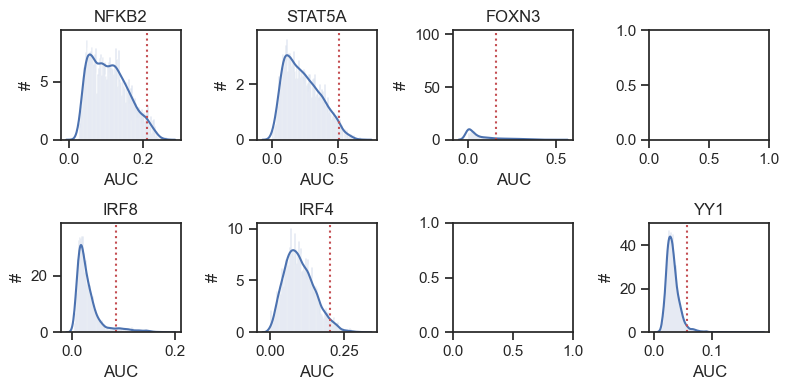

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.set(font_scale=1)
    sns.set_style("ticks")

    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 4), dpi=100)

    plot_binarization(auc_mtx, 'NFKB2', thresholds['NFKB2'], ax=ax1)
    plot_binarization(auc_mtx, 'STAT5A', thresholds['STAT5A'], ax=ax2)
    plot_binarization(auc_mtx, 'FOXN3', thresholds['FOXN3'], ax=ax3)
    # plot_binarization(auc_mtx, 'BATF3', thresholds['BATF3'], ax=ax4)
    plot_binarization(auc_mtx, 'IRF8', thresholds['IRF8'], ax=ax5)
    plot_binarization(auc_mtx, 'IRF4', thresholds['IRF4'], ax=ax6)
    # plot_binarization(auc_mtx, 'ZEB1', thresholds['ZEB1'], ax=ax7)
    plot_binarization(auc_mtx, 'YY1', thresholds['YY1'], ax=ax8)

    plt.tight_layout()
    savesvg('hists - GSE115978 - binarization.png', fig)

In [25]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['white'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [26]:
adata.obs['cell_type_condition'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
adata.obs['cell_type_ebv'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.ebv_status.astype(str)

In [27]:
catagories = 'donor'
N_COLORS = len(adata.obs[catagories].unique())
COLORS = [color for color in sns.color_palette("tab10")][:N_COLORS]
df_metadata = adata.obs 
cell_type_color_lut = dict(zip(adata.obs[catagories].unique(), COLORS))
cell_id2cell_type_lut = df_metadata[catagories].to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

In [25]:
plt.rcParams['figure.dpi'] = 100

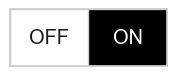

In [26]:
sns.set()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('legend - chl - on_off.svg', fig)

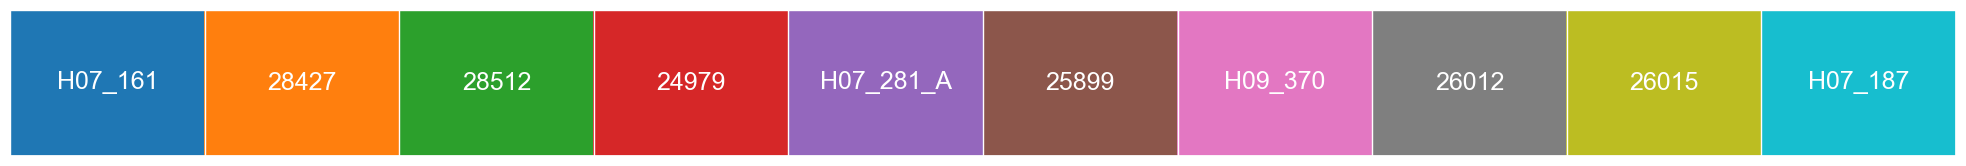

In [27]:
sns.set()
sns.set(font_scale=1.5)
fig = palplot(sns.color_palette(COLORS), adata.obs[catagories].unique(), size=2.0)
savesvg('legend - chl - cell_type_colors.svg', fig)

/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


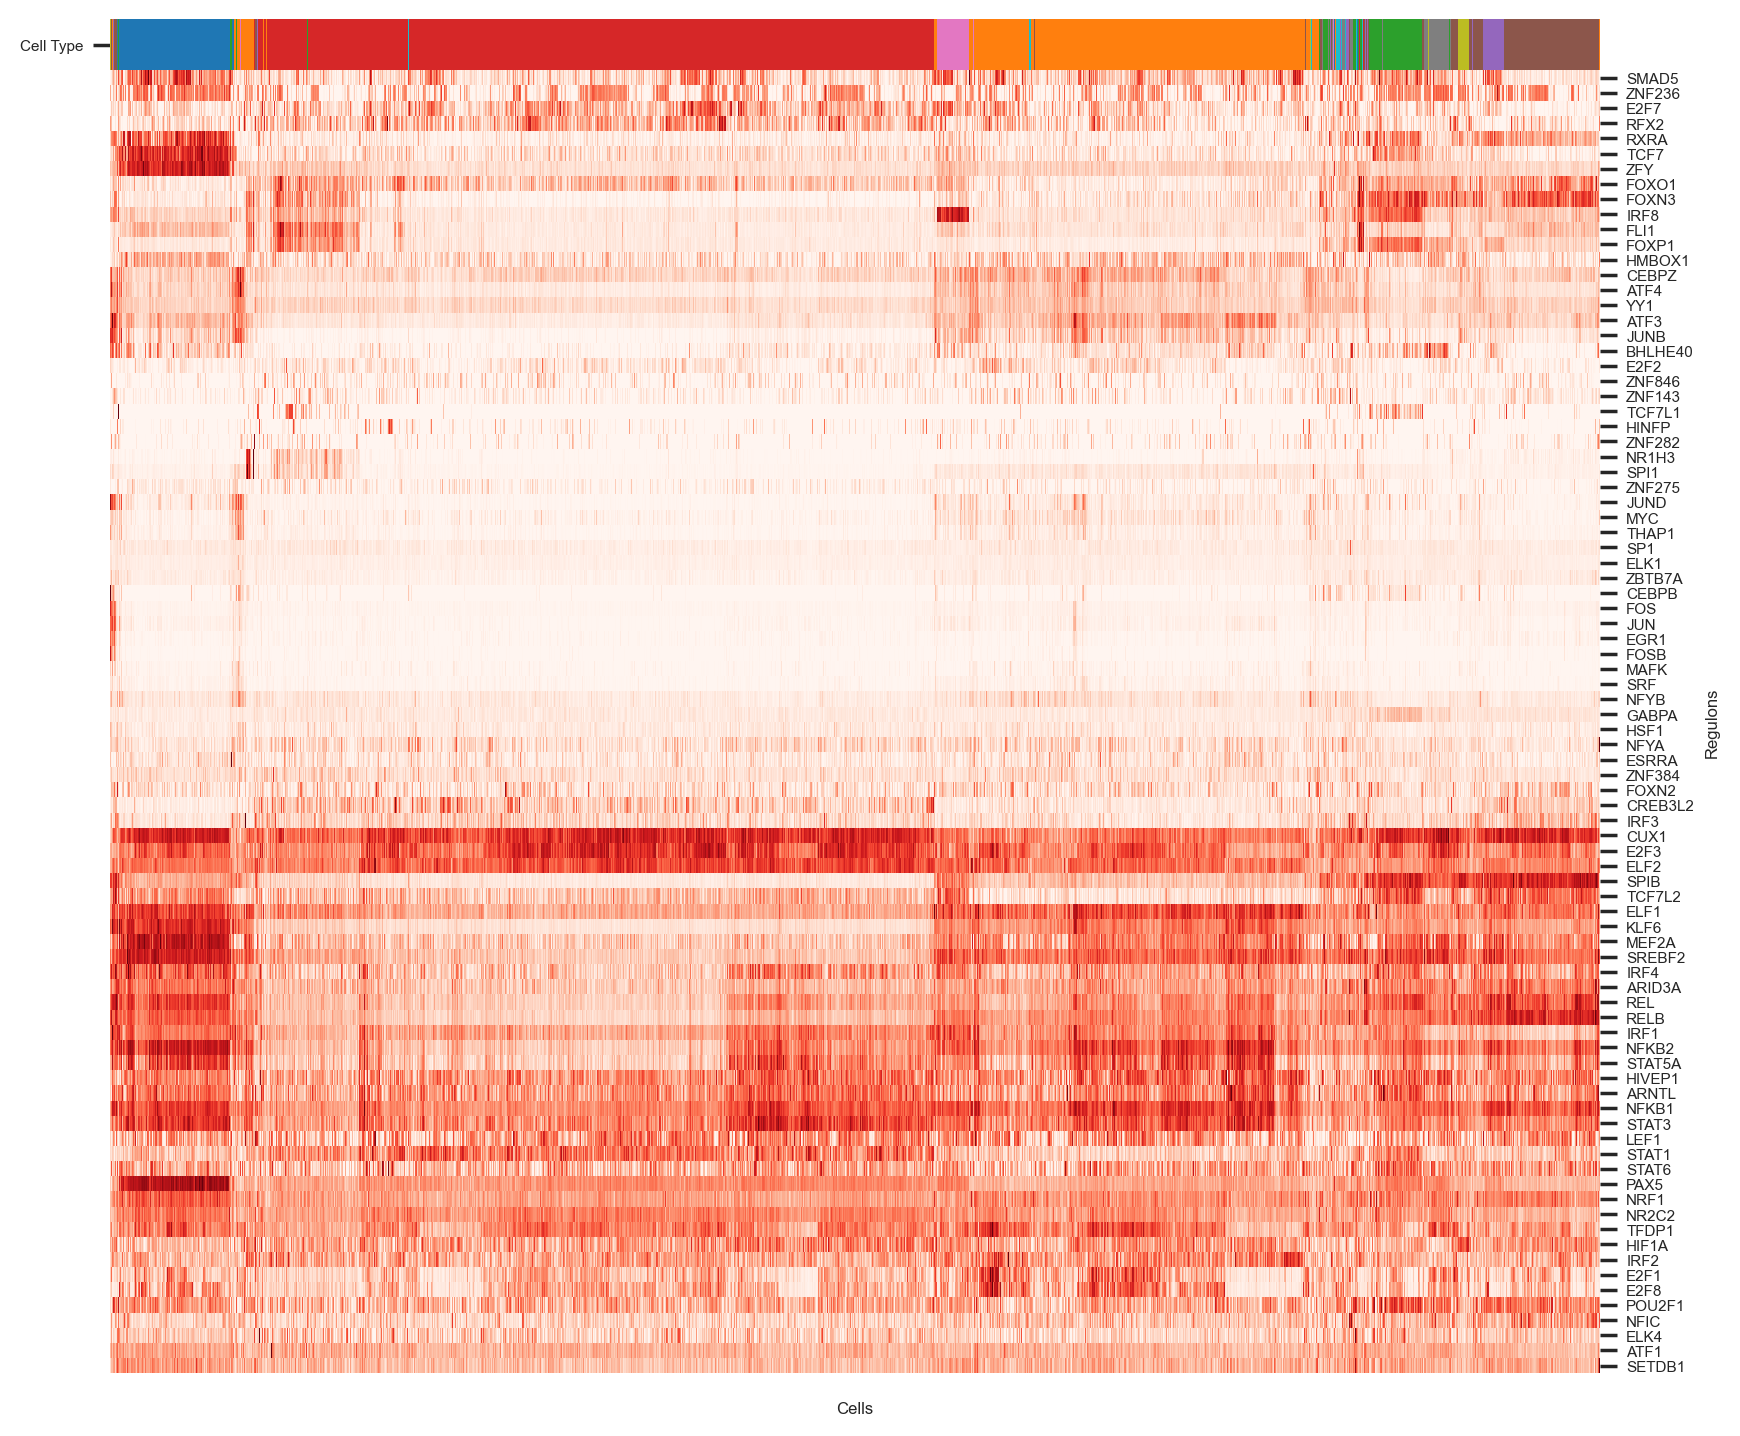

In [64]:
norm_auc = auc_mtx/auc_mtx.max()

sns.set()
plt.rcParams['figure.dpi'] = 200
sns.set(font_scale=0.5)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})

g = sns.clustermap(
    norm_auc.T, 
    col_colors=auc_mtx.index.map(cell_id2cell_type_lut).map(cell_type_color_lut),
    # cmap=bw_palette, 
    cmap='Reds',
    figsize=(10,10), 
    yticklabels=True
)
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.savefig(os.path.join(FIGURES_FOLDERNAME, 'clustermap2 - chl.png'), format='png')

In [65]:
bin_mtx_clustered = bin_mtx.T.copy()
bin_mtx_clustered.rename(columns=adata.obs['cell_type'].to_dict(), inplace=True)
bin_mtx_clustered.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind].\
    to_csv(os.path.join(RESULTS_FOLDERNAME, 'binarized_regulon_activity.csv'))

In [66]:
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [67]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [68]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons[df_regulons.name.isin(['STAT5A', 'NFKB1', 'IRF8', 'IRF4', 'LEF1'])].to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

/tmp/ipykernel_3278/3887940640.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,name,count,logo
37,IRF4,32,
38,IRF8,381,
43,LEF1,12,
48,NFKB1,994,
70,STAT5A,31,


***
***
    Dim reduction and clustering
***
***

In [69]:
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
sc.tl.pca(adata, svd_solver='arpack')
sc.tl.tsne(adata)

/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm['X_pca'] = X_pca


/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


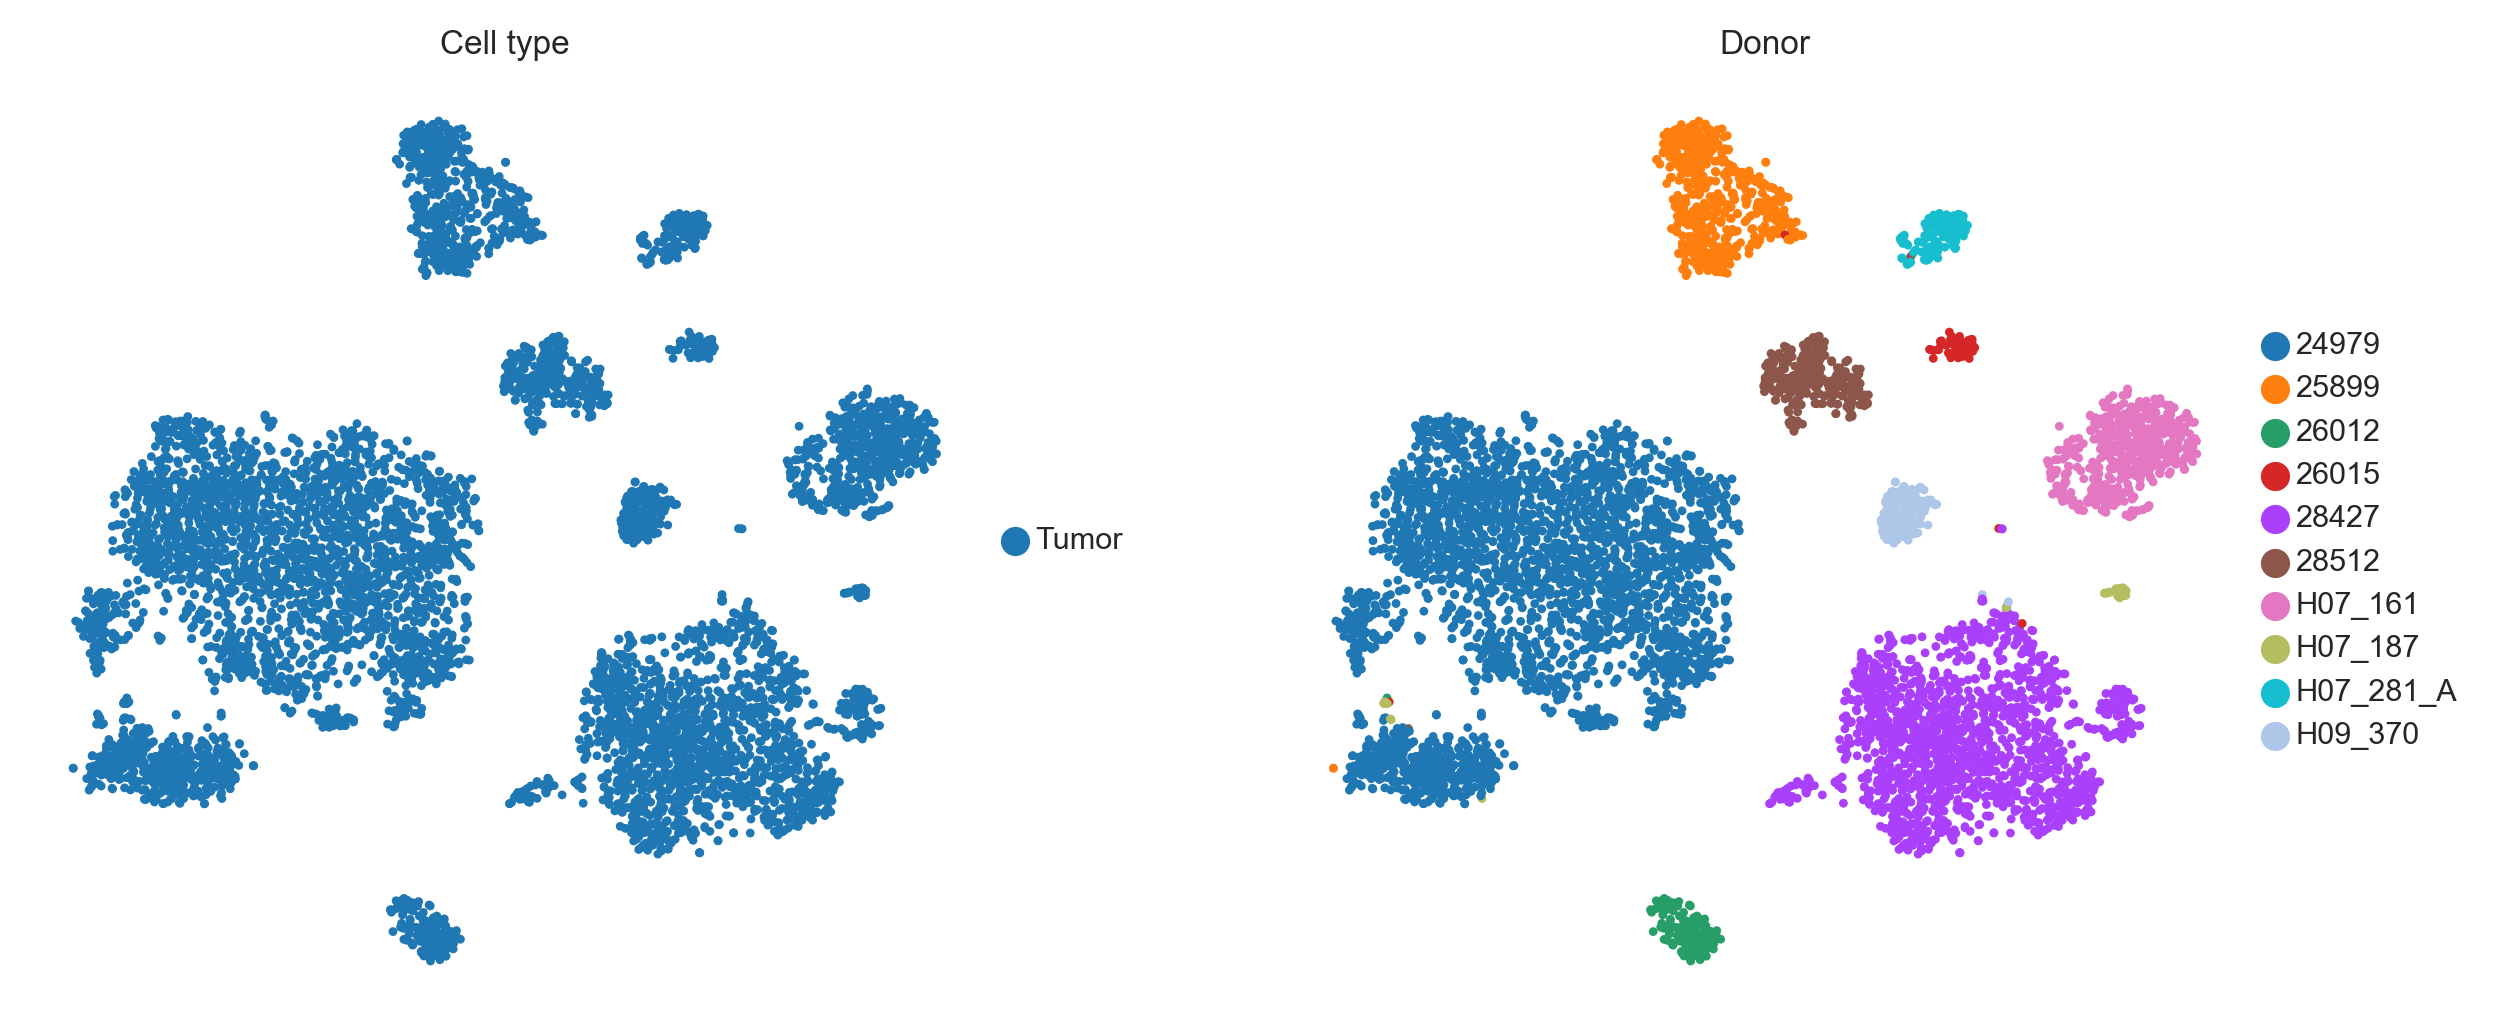

In [70]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'donor'], title=['Cell type', 'Donor'], ncols=2, save='celltype_donor_PCA_tSNE.svg')

In [71]:
add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

In [95]:
adata = ad.read_h5ad(ANNDATA_FNAME)

In [73]:
sc.tl.tsne(adata, use_rep='X_aucell')

/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


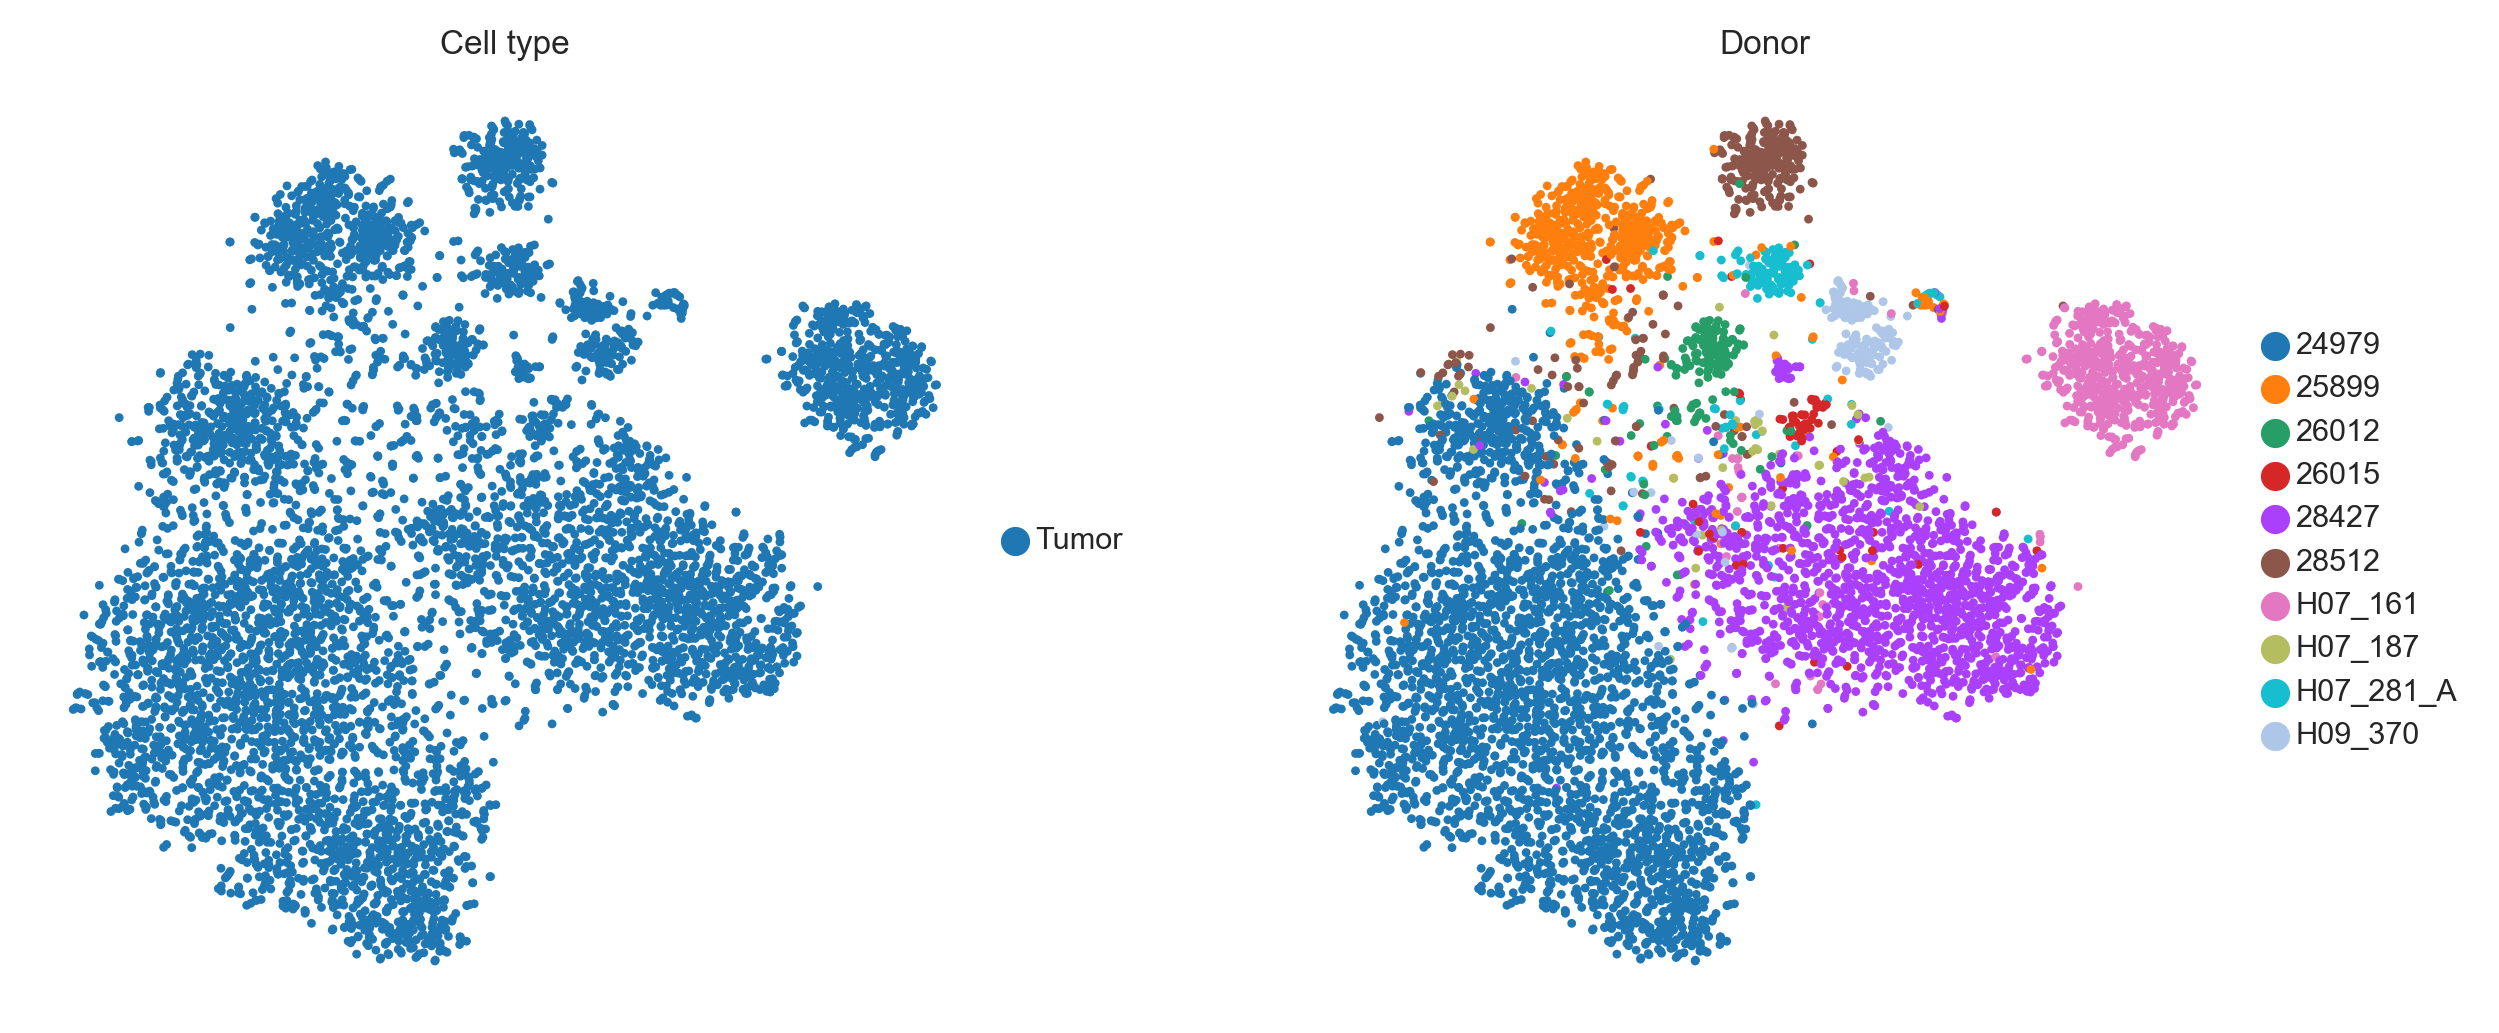

In [74]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'donor'], title=['Cell type', 'Donor'], ncols=2, save='scenic_celltype_donor_PCA_tSNE.svg')

In [75]:
group_by = 'cell_type'
rss = regulon_specificity_scores(auc_mtx, adata.obs[group_by])
rss.head()

,ARID3A,ARNTL,ATF1,ATF3,ATF4,BHLHE40,CEBPB,CEBPZ,CREB3L2,CUX1,...,THAP1,YY1,ZBTB7A,ZFY,ZNF143,ZNF236,ZNF275,ZNF282,ZNF384,ZNF846
Tumor,0.857283,0.849476,0.910857,0.764051,0.774503,0.5636,0.315377,0.833702,0.746953,0.902131,...,0.612028,0.881842,0.737996,0.782082,0.487743,0.590129,0.496581,0.341217,0.823335,0.436304


In [82]:
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + [group_by]]
df_results = ((df_scores.groupby(by=group_by).mean() - \
               df_obs[signature_column_names].mean())/ \
              df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(abs(df_results.Z) >= 0.5)].sort_values('Z', ascending=False)

,cell_type,regulon,Z


In [80]:
## sns.set_style("ticks")
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 1].sort_values('Z', ascending=False),
                           index=group_by, columns='regulon', values='Z')
# fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
# sns.heatmap(df_heatmap[g.data2d.columns], ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
#             cmap="Reds", annot_kws={"size": 6})
g = sns.clustermap(df_heatmap.fillna(0), figsize=(16,4), annot=False, fmt=".1f", linewidths=.7, square=True, linecolor='black',
            cmap="Reds", annot_kws={"size": 6})
ax1.set_ylabel('')
savesvg('heatmap - chl - regulons.svg', fig)

In [83]:
tumor_regulons = df_results[(df_results.Z > 1) & (df_results.cell_type == 'Tumor')]
print(tumor_regulons.regulon.values)

[]

In [ ]:
tumor_regulons = {reg.name: reg for reg in regulons if reg.name in tumor_regulons.regulon.values}

In [56]:
G = nx.Graph()

for regulon in tumor_regulons.values():
    for target, weight in regulon.gene2weight.items():
        if weight > 12:
            G.add_edge(regulon.transcription_factor, target, weight=1)
            
pos = nx.spring_layout(G, seed=7)  

In [ ]:
nt = Network(notebook=True)
nt.from_nx(G)
nt.show('nx2.html')

/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dchafamo/anaconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


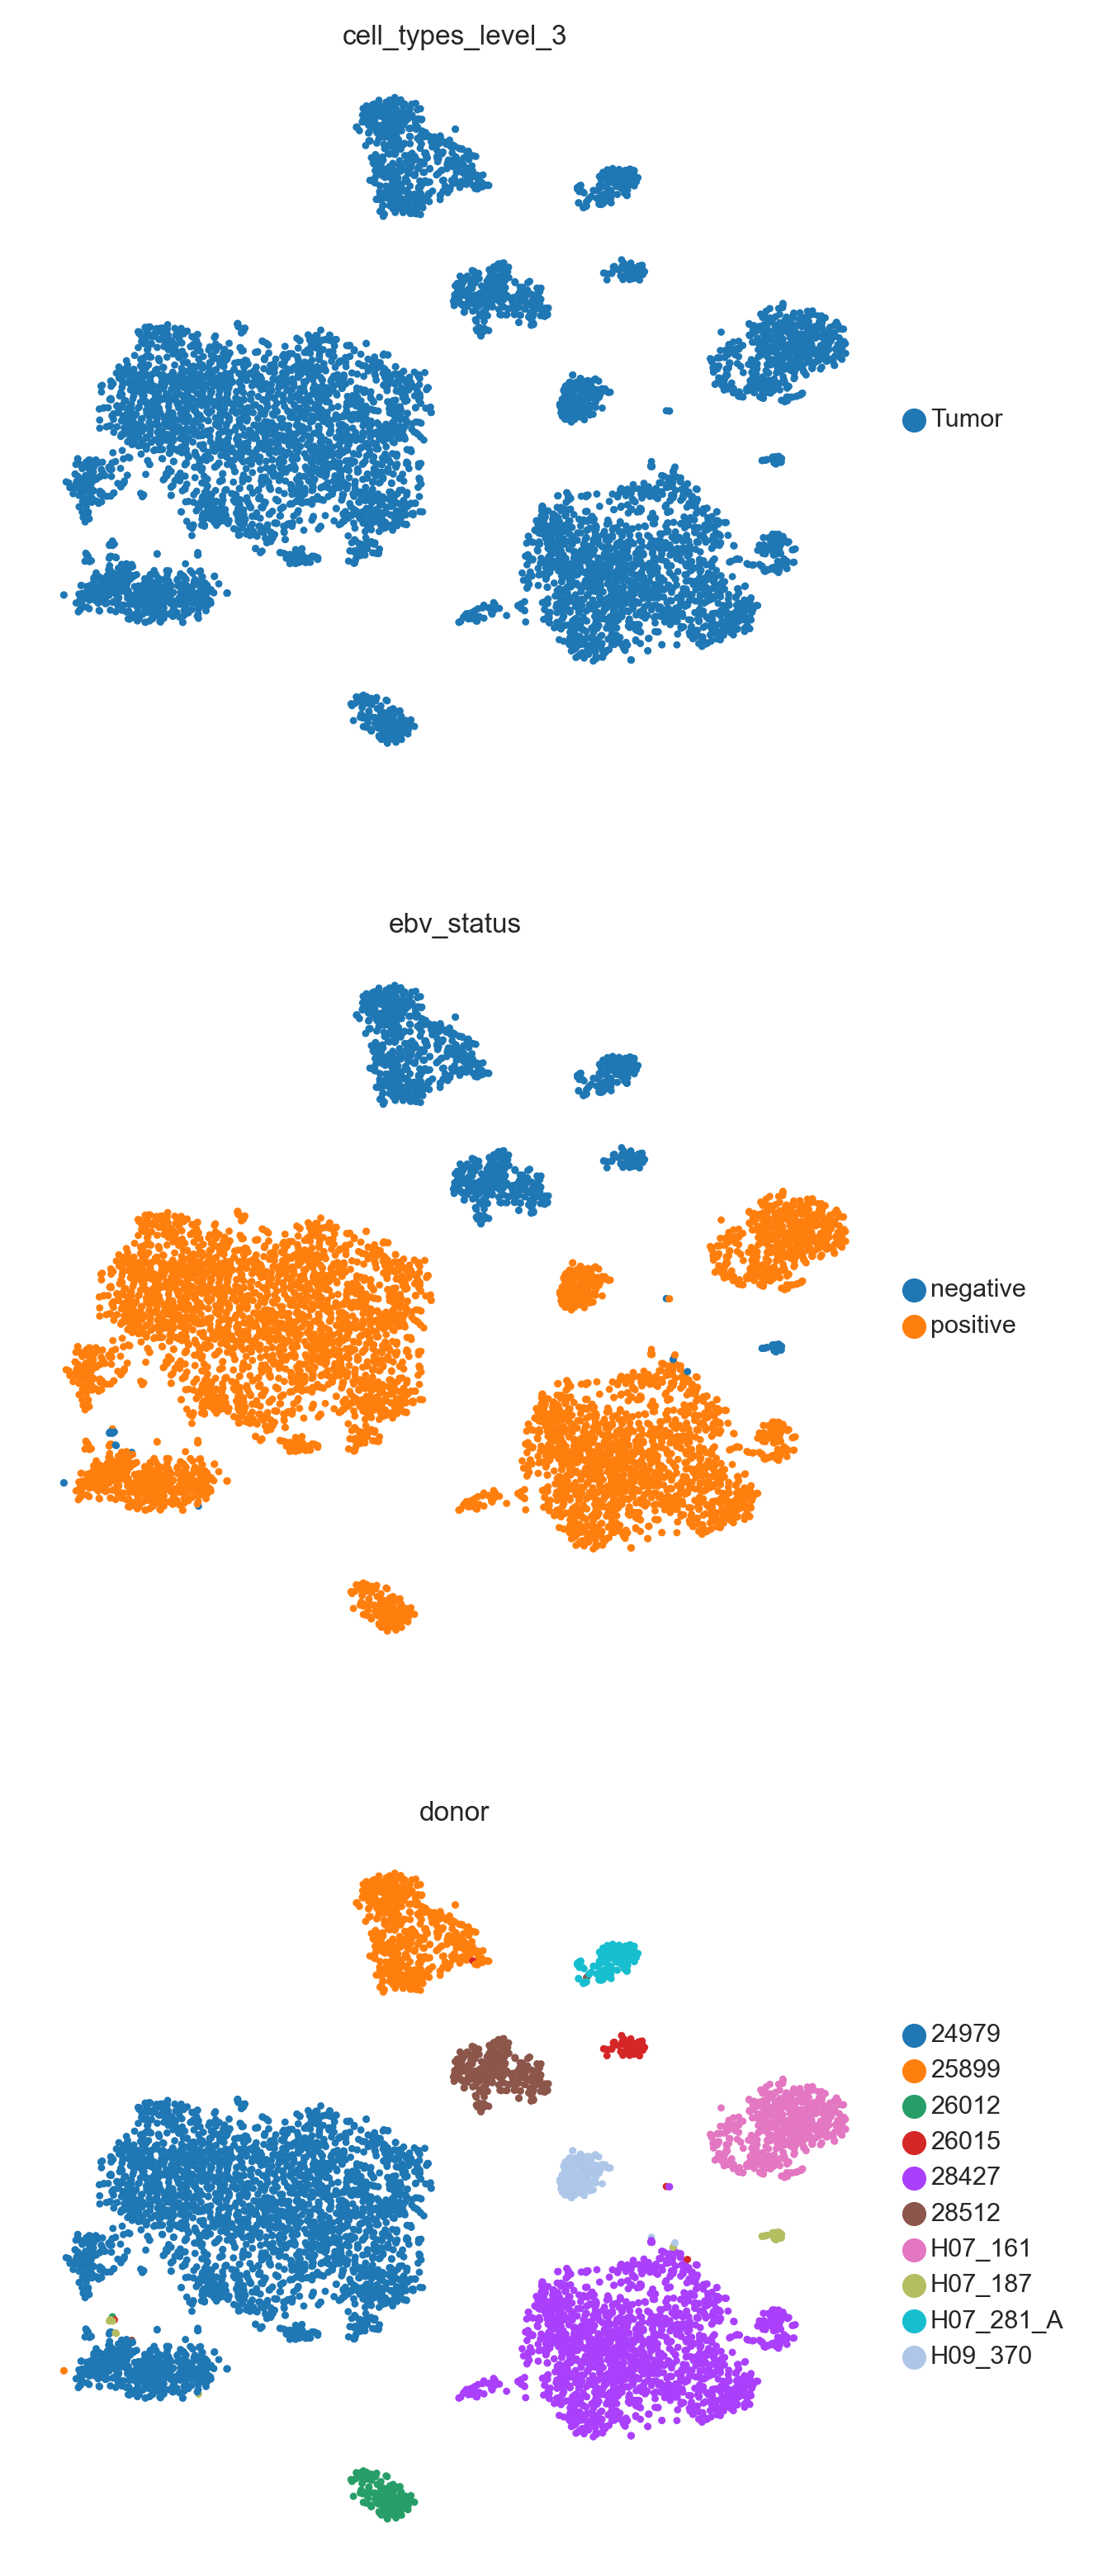

In [98]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_types_level_3', 'ebv_status', 'donor'], 
           ncols=1, use_raw=False,
          save=' - chl - metadata.png')

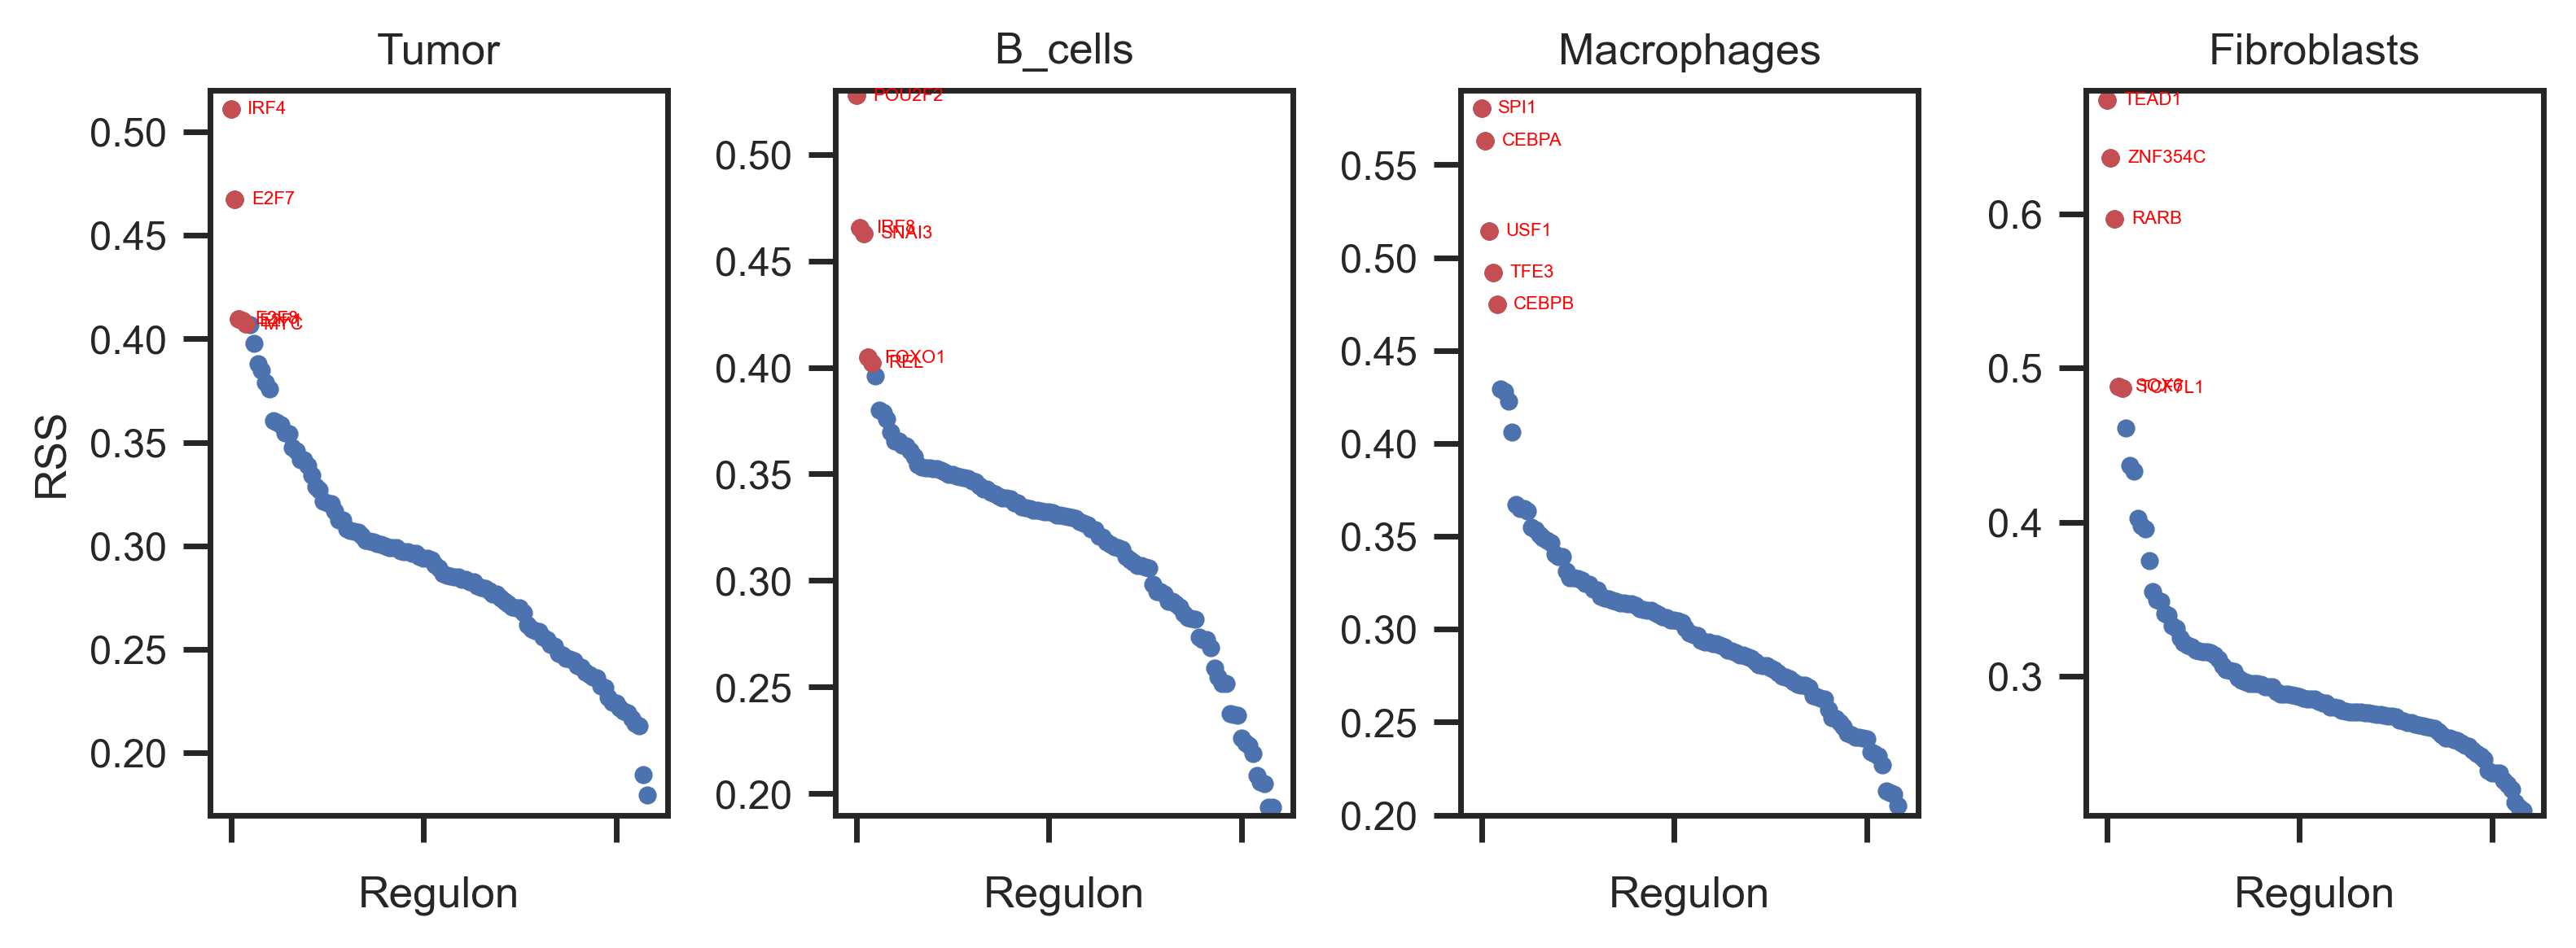

In [77]:
sns.set(font_scale=0.8)
sns.set_style("ticks")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8, 3), dpi=200)
plot_rss(rss, 'Tumor', ax=ax1)
plot_rss(rss, 'B_cells', ax=ax2)
ax2.set_ylabel('')
plot_rss(rss, 'Macrophages', ax=ax3)
ax3.set_ylabel('')
plot_rss(rss, 'Fibroblasts', ax=ax4)
ax4.set_ylabel('')
plt.tight_layout()
savesvg('plots - GSE115978 - rss.svg', fig)